In [1]:
import pandas as pd
from mira.modeling import Concept, TemplateModel, Annotations
from mira.sources.system_dynamics.vensim import template_model_from_mdl_url, template_model_from_mdl_file
from mira.modeling.amr.stockflow import template_model_to_stockflow_json
import os
from urllib.request import urlretrieve
import json
from pathlib import Path
from tqdm.auto import tqdm, trange
import networkx as nx

In [2]:
HERE = Path(".").resolve()

## Grounding Map

Load a custom grounding map, which lets us assign identifiers and contexts to most of the compartments.

In [3]:
grounding_map_df = pd.read_csv("grounding_map.csv")
# grounding_map_df

In [4]:
def curie_to_identifiers(curie):
    prefix, identifier = curie.split(":")
    return {prefix: identifier}

grounding_map = {}
for display_name, identifiers, context_str in grounding_map_df.values:
    if pd.isna(identifiers):
        continue
    curie, name =  identifiers.split("/")
    context = {}
    if pd.notna(context_str):
        for part in context_str.split("|"):
            part_key, part_identifier = part.split("=")
            if "/" in part_identifier:
                part_curie, part_name = part_identifier.split("/")
            else:
                part_curie, part_name = part_identifier, None
            # print(curie, name, part_key, part_curie, part_name)
            context[part_key] = part_curie
            
    grounding_map[display_name] = Concept(
        name=name, 
        display_name=display_name,
        identifiers=curie_to_identifiers(curie),
        context=context,
    )

## Ingest the hackathon Vensim model and display its structure

In [5]:
hackathon_file_path = "IndiaNonSubscriptedPulsed.mdl"
hackathon_file_url = (
    "https://raw.githubusercontent.com/DARPA-ASKEM/program-milestones/main/18-"
    "month-milestone/hackathon/epi/Scenario%205%20Supplemental/IndiaNonSubscriptedPulsed.mdl"
)
initials = {"susceptibles": 1.3392e+09}

if not os.path.exists(hackathon_file_path):
    urlretrieve(hackathon_file_url, hackathon_file_path)
    

In [6]:
import pysd
from pysd.translators.vensim.vensim_file import VensimFile
import sympy
from mira.sources.system_dynamics.vensim import extract_vensim_variable_expressions
from mira.sources.system_dynamics.pysd import preprocess_expression_text
from mira.metamodel.utils import safe_parse_expr

pysd_model = pysd.read_vensim(hackathon_file_path)
vensim_file = VensimFile(hackathon_file_path)

In [7]:
# get all stocks
stock_states = {
    name: sympy.Symbol(name)
    for name in pysd_model.doc.loc[
        (pysd_model.doc["Type"] == "Stateful")
        & (pysd_model.doc["Subtype"] == "Integ")
    ]["Py Name"]
}
stock_states

{'cumulative_cases_reported': cumulative_cases_reported,
 'dead': dead,
 'exposed': exposed,
 'incoming_demand_on_hospital': incoming_demand_on_hospital,
 'infected_sym_extreme_icu': infected_sym_extreme_icu,
 'infected_sym_hospital_overflow': infected_sym_hospital_overflow,
 'infected_sym_icu_overflow': infected_sym_icu_overflow,
 'infected_sym_serious_hospital': infected_sym_serious_hospital,
 'infectious_asymptomatics': infectious_asymptomatics,
 'infectious_symptomatics_mild': infectious_symptomatics_mild,
 'isolated_asymptomatics': isolated_asymptomatics,
 'isolated_symtomatics_mild': isolated_symtomatics_mild,
 'quarantined_asymptomatics': quarantined_asymptomatics,
 'quarantined_symtomatics_mild': quarantined_symtomatics_mild,
 'recovered_asymtomatics': recovered_asymtomatics,
 'recovered_isolated_symptomatic_mild': recovered_isolated_symptomatic_mild,
 'recovered_from_hospital': recovered_from_hospital,
 'recovered_mild': recovered_mild,
 'susceptibles': susceptibles}

In [8]:
aux_states = {
    name: sympy.Symbol(name)
    for name in pysd_model.doc.loc[
        (pysd_model.doc["Type"] == "Auxiliary")
    ]["Py Name"]
}

In [9]:
states = {
    name: sympy.Symbol(name)
    for name in pysd_model.doc["Py Name"]
}

norm_names = dict(
    pysd_model.doc[["Real Name", "Py Name"]].values
)

In [10]:
expression_map, _ = extract_vensim_variable_expressions(
    vensim_file.model_text, initials_from_integ=True,
)
norm_name_to_expr = {}
for k,v in expression_map.items():
    processed_v = preprocess_expression_text(v)
    try:
        expr = safe_parse_expr(processed_v, states)
    except TypeError as e:
        print(f"[{k}] failed to parse:\n{processed_v}\n{e}\n")
        continue
    norm_name_to_expr[sympy.Symbol(norm_names[k])] = expr

In [11]:
ex = list(norm_name_to_expr.items())[2][1]
ex

pulse_train(lock_down_start_day, lock_down_duration, lock_down_duration + open_duration, end_lockdown_time)

In [12]:
# look at all expressions from the Vensim model and make a graph
# of dependencies where edge (u,v) means u depends on v.
# the keys in norm_name_to_expr can be both stocks and flows
graph = nx.DiGraph()
for symbol, expr in norm_name_to_expr.items():
    for arg in expr.free_symbols:
        graph.add_edge(symbol, arg)

In [13]:
from networkx.algorithms.dag import topological_sort
from IPython.display import display

# This works correctly, but there's an issue with "effect of density on contacts"
flow_dependencies = graph.subgraph(aux_states.values())
flow_dependencies_agraph = nx.nx_agraph.to_agraph(flow_dependencies)
flow_dependencies_agraph.draw("flows.pdf", prog="dot")

# Traverse in reverse topological sort order, meaning that at any
# position, all of the things that position depends on will have
# already come. This means we only need one pass for making substitutions
# for everything in the current position with ones that have already been
# seen and substituted before
flow_order = list(reversed(list(topological_sort(flow_dependencies))))

In [14]:
new_norm_name_to_expr = norm_name_to_expr.copy()

for symbol in tqdm(flow_order):
    expr = norm_name_to_expr[symbol]
    mappable = set(expr.free_symbols).intersection(norm_name_to_expr)
    print(symbol, len(mappable))
    display(expr)
    
    for s in mappable:
        expr = expr.subs(s, new_norm_name_to_expr[s])

    display(expr)
    print()
    
    new_norm_name_to_expr[symbol] = expr

  0%|          | 0/94 [00:00<?, ?it/s]

density_of_state 2


total_population/area_of_states

1339200000.00000


density_ratio 2


0.001*density_of_state/reference_population_density + 1

1339201.00000000


sum_asymtomatics 1


infectious_asymptomatics

infection_rate_new_arrivals + infectivity_setting - isolation_rate_asym - quarantining_rate_asym - recoveries_asym - symptom_setting


sum_recovered 4


recovered_asymtomatics + recovered_from_hospital + recovered_isolated_symptomatic_mild + recovered_mild

recoveries_asym + recoveries_icu + recoveries_icu_overflow + recoveries_infected_sym_mild + recoveries_iso_asym + recoveries_iso_sym + recoveries_q_asym + recoveries_qsym + recoveries_serioush + recoveries_serioush_overflow


sum_susceptibles 1


susceptibles

-exposure


effect_of_density_on_contacts 1


piecewise((1, density_ratio <= 1), (log(density_ratio)/log(50) + 1, True))

piecewise((1, False), (1 + 14.1075837254315/log(50), True))


sum_susc_asymp_recov_can_work 3


sum_asymtomatics + sum_recovered + sum_susceptibles

-exposure + infection_rate_new_arrivals + infectivity_setting - isolation_rate_asym - quarantining_rate_asym + recoveries_icu + recoveries_icu_overflow + recoveries_infected_sym_mild + recoveries_iso_asym + recoveries_iso_sym + recoveries_q_asym + recoveries_qsym + recoveries_serioush + recoveries_serioush_overflow - symptom_setting


normal_contacts_per_day 5


effect_of_density_on_contacts*(base_contact_home + base_contact_school + base_contact_work + base_contacts_other)

26*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


net_contacts_school 3


base_contact_school*effect_of_density_on_contacts*policy_multiplier_school

5*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


net_contacts_work 3


base_contact_work*effect_of_density_on_contacts*policy_multiplier_work

7*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


net_contacts_home 3


base_contact_home*effect_of_density_on_contacts*policy_multiplier_home

8*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


net_contacts_other 3


base_contacts_other*effect_of_density_on_contacts*policy_multiplier_other

6*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


fraction_cant_work 2


-sum_susc_asymp_recov_can_work/total_population + 1

7.46714456391876e-10*exposure - 7.46714456391876e-10*infection_rate_new_arrivals - 7.46714456391876e-10*infectivity_setting + 7.46714456391876e-10*isolation_rate_asym + 7.46714456391876e-10*quarantining_rate_asym - 7.46714456391876e-10*recoveries_icu - 7.46714456391876e-10*recoveries_icu_overflow - 7.46714456391876e-10*recoveries_infected_sym_mild - 7.46714456391876e-10*recoveries_iso_asym - 7.46714456391876e-10*recoveries_iso_sym - 7.46714456391876e-10*recoveries_q_asym - 7.46714456391876e-10*recoveries_qsym - 7.46714456391876e-10*recoveries_serioush - 7.46714456391876e-10*recoveries_serioush_overflow + 7.46714456391876e-10*symptom_setting + 1


contact_under_lockdown_per_day 2


lockdown_effect_on_contacts*normal_contacts_per_day

7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


net_contacts_sum 4


net_contacts_home + net_contacts_other + net_contacts_school + net_contacts_work

26*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


fraction_healthcare_cant_work 2


fraction_cant_work + (1 - fraction_cant_work)*(1 - ppe_availability)

5.97371565113501e-10*exposure - 5.97371565113501e-10*infection_rate_new_arrivals - 5.97371565113501e-10*infectivity_setting + 5.97371565113501e-10*isolation_rate_asym + 5.97371565113501e-10*quarantining_rate_asym - 5.97371565113501e-10*recoveries_icu - 5.97371565113501e-10*recoveries_icu_overflow - 5.97371565113501e-10*recoveries_infected_sym_mild - 5.97371565113501e-10*recoveries_iso_asym - 5.97371565113501e-10*recoveries_iso_sym - 5.97371565113501e-10*recoveries_q_asym - 5.97371565113501e-10*recoveries_qsym - 5.97371565113501e-10*recoveries_serioush - 5.97371565113501e-10*recoveries_serioush_overflow + 5.97371565113501e-10*symptom_setting + 1.0


high_contact_tracing_and_isolation 2


piecewise((0, time < april_14), (policy_high_contact_tracing_and_isolation, True))

piecewise((0, time < 50), (0, True))


lack_of_awareness_multiplier 4


loastartlevel + ramp((loaendlevel - loastartlevel)/(loaendtime - loastarttime), loastarttime, loaendtime)

ramp(-0.00571428571428571, 15, 50) + 1.2


contacts_q_asym_per_day 2


net_contacts_home*quarantine_effect_on_asym_contacts

8*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


total_population_in_agegroup 1


total_population

1339200000.00000


contacts_per_day 2


piecewise((contact_under_lockdown_per_day, False), (net_contacts_sum, True))

piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True))


contacts_iso_sym_per_day 2


isolation_effect_on_sym_contacts*net_contacts_home

4.0*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


contacts_iso_asym_per_day 2


isolation_effect_on_asym_contacts*net_contacts_home

4.0*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


contacts_q_sym_per_day 2


net_contacts_home*quarantine_effect_on_sym_contacts

6.0*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


icu_capacity 5


healthcare_capacity_multiplier*normal_icu_capacity_per_person*patients_per_unit*total_population*(1 - fraction_healthcare_cant_work)

-0.00368*exposure + 0.00368*infection_rate_new_arrivals + 0.00368*infectivity_setting - 0.00368*isolation_rate_asym - 0.00368*quarantining_rate_asym + 0.00368*recoveries_icu + 0.00368*recoveries_icu_overflow + 0.00368*recoveries_infected_sym_mild + 0.00368*recoveries_iso_asym + 0.00368*recoveries_iso_sym + 0.00368*recoveries_q_asym + 0.00368*recoveries_qsym + 0.00368*recoveries_serioush + 0.00368*recoveries_serioush_overflow - 0.00368*symptom_setting


contact_tracing_policy 3


high_contact_tracing_and_isolation*(high_contact_tracing_policy - low_contact_tracing_policy) + low_contact_tracing_policy

0.1 + 0.7*piecewise((0, time < 50), (0, True))


fr_symptomatic_tested_isolated 3


high_contact_tracing_and_isolation*(high_fr_iso_sym - low_fr_iso_sym) + low_fr_iso_sym

0.25 + 0.55*piecewise((0, time < 50), (0, True))


interaction_intensity 2


piecewise((lack_of_awareness_multiplier, time < april_14), (lack_of_awareness_multiplier, True))

piecewise((ramp(-0.00571428571428571, 15, 50) + 1.2, time < 50), (ramp(-0.00571428571428571, 15, 50) + 1.2, True))


contacts_with_asym_in_q 4


contacts_q_asym_per_day*quarantined_asymptomatics*(1 - infectivity_reduction_for_asym)/total_population_in_agegroup

2.9868578255675e-9*(-incubation_rate_quarantines + quarantining_rate_asym - recoveries_q_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


contacts_with_sypmtomatics_mild 3


contacts_per_day*infectious_symptomatics_mild/total_population_in_agegroup

7.46714456391876e-10*(-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True))


contacts_with_sym_in_isolation 3


contacts_iso_sym_per_day*isolated_symtomatics_mild/total_population_in_agegroup

2.9868578255675e-9*(incubation_rate_iso - iso_disease_progress_rate + isolation_rate_sym - recoveries_iso_sym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


contacts_with_asym_in_isolation 4


contacts_iso_asym_per_day*isolated_asymptomatics*(1 - infectivity_reduction_for_asym)/total_population_in_agegroup

1.49342891278375e-9*(-incubation_rate_iso + isolation_rate_asym - recoveries_iso_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


contacts_with_asymptomatics 4


contacts_per_day*infectious_asymptomatics*(1 - infectivity_reduction_for_asym)/total_population_in_agegroup

3.73357228195938e-10*(infection_rate_new_arrivals + infectivity_setting - isolation_rate_asym - quarantining_rate_asym - recoveries_asym - symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True))


contacts_with_sym_in_q 3


contacts_q_sym_per_day*quarantined_symtomatics_mild/total_population_in_agegroup

4.48028673835125e-9*(incubation_rate_quarantines - q_disease_progress_rate + quarantine_rate_sym - recoveries_qsym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


managable_icu_inflow 3


Max(0, (icu_capacity - infected_sym_extreme_icu)*xidz(typical_worsening_rate, typical_worsening_rate, 1)/time_step)

Max(0, (deaths - 0.00368*exposure - icu_admissions + 0.00368*infection_rate_new_arrivals + 0.00368*infectivity_setting - 0.00368*isolation_rate_asym - 0.00368*quarantining_rate_asym + 1.00368*recoveries_icu + 0.00368*recoveries_icu_overflow + 0.00368*recoveries_infected_sym_mild + 0.00368*recoveries_iso_asym + 0.00368*recoveries_iso_sym + 0.00368*recoveries_q_asym + 0.00368*recoveries_qsym + 0.00368*recoveries_serioush + 0.00368*recoveries_serioush_overflow - 0.00368*symptom_setting)*xidz(fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), 1)/time_step)


hospital_bed_capacity 5


healthcare_capacity_multiplier*normal_hospital_beds_per_person*patients_per_unit*total_population*(1 - fraction_healthcare_cant_work)

-0.144*exposure + 0.144*infection_rate_new_arrivals + 0.144*infectivity_setting - 0.144*isolation_rate_asym - 0.144*quarantining_rate_asym + 0.144*recoveries_icu + 0.144*recoveries_icu_overflow + 0.144*recoveries_infected_sym_mild + 0.144*recoveries_iso_asym + 0.144*recoveries_iso_sym + 0.144*recoveries_q_asym + 0.144*recoveries_qsym + 0.144*recoveries_serioush + 0.144*recoveries_serioush_overflow - 0.144*symptom_setting


fr_q_asym_via_tracing 2


contact_tracing_policy*fr_symptomatic_tested_isolated

(0.1 + 0.7*piecewise((0, time < 50), (0, True)))*(0.25 + 0.55*piecewise((0, time < 50), (0, True)))


infectivity 2


default_infectivity*interaction_intensity

0.015*piecewise((ramp(-0.00571428571428571, 15, 50) + 1.2, time < 50), (ramp(-0.00571428571428571, 15, 50) + 1.2, True))


contacts_total_per_susceptible 6


contacts_with_asym_in_isolation + contacts_with_asym_in_q + contacts_with_asymptomatics + contacts_with_sym_in_isolation + contacts_with_sym_in_q + contacts_with_sypmtomatics_mild

1.49342891278375e-9*(-incubation_rate_iso + isolation_rate_asym - recoveries_iso_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(-incubation_rate_quarantines + quarantining_rate_asym - recoveries_q_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(incubation_rate_iso - iso_disease_progress_rate + isolation_rate_sym - recoveries_iso_sym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 4.48028673835125e-9*(incubation_rate_quarantines - q_disease_progress_rate + quarantine_rate_sym - recoveries_qsym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 7.46714456391876e-10*(-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True)) + 3.73357228195938e-10*(infection_rate_new_arrivals


infection_rate_new_arrivals 0


piecewise((0.0, time >= 0.0), (2.0, time >= 1.0), (1.0, time >= 2.0), (0.0, time >= 3.0), (2.0, time >= 4.0), (1.0, time >= 5.0), (2.0, time >= 6.0), (3.0, time >= 7.0), (6.0, time >= 8.0), (2.0, time >= 9.0), (7.0, time >= 10.0), (10.0, time >= 11.0), (4.0, time >= 12.0), (10.0, time >= 13.0), (5.0, time >= 14.0), (11.0, time >= 15.0), (14.0, time >= 16.0), (14.0, time >= 17.0), (26.0, time >= 18.0), (34.0, time >= 19.0), (35.0, time >= 20.0), (45.0, time >= 21.0), (55.0, time >= 22.0), (38.0, time >= 23.0), (34.0, time >= 24.0), (24.0, time >= 25.0), (40.0, time >= 26.0), (16.0, time >= 27.0), (20.0, time >= 28.0), (12.0, time >= 29.0), (23.0, time >= 30.0), (14.0, time >= 31.0), (8.0, time >= 32.0), (14.0, time >= 33.0), (12.0, time >= 34.0), (5.0, time >= 35.0), (9.0, time >= 36.0), (6.0, time >= 37.0), (0.0, time >= 38.0), (0.0, time >= 39.0), (0.0, time >= 40.0), (0.0, time >= 1000.0))

piecewise((0.0, time >= 0.0), (2.0, time >= 1.0), (1.0, time >= 2.0), (0.0, time >= 3.0), (2.0, time >= 4.0), (1.0, time >= 5.0), (2.0, time >= 6.0), (3.0, time >= 7.0), (6.0, time >= 8.0), (2.0, time >= 9.0), (7.0, time >= 10.0), (10.0, time >= 11.0), (4.0, time >= 12.0), (10.0, time >= 13.0), (5.0, time >= 14.0), (11.0, time >= 15.0), (14.0, time >= 16.0), (14.0, time >= 17.0), (26.0, time >= 18.0), (34.0, time >= 19.0), (35.0, time >= 20.0), (45.0, time >= 21.0), (55.0, time >= 22.0), (38.0, time >= 23.0), (34.0, time >= 24.0), (24.0, time >= 25.0), (40.0, time >= 26.0), (16.0, time >= 27.0), (20.0, time >= 28.0), (12.0, time >= 29.0), (23.0, time >= 30.0), (14.0, time >= 31.0), (8.0, time >= 32.0), (14.0, time >= 33.0), (12.0, time >= 34.0), (5.0, time >= 35.0), (9.0, time >= 36.0), (6.0, time >= 37.0), (0.0, time >= 38.0), (0.0, time >= 39.0), (0.0, time >= 40.0), (0.0, time >= 1000.0))


avg_contact 1


normal_contacts_per_day

26*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


icu_overflow 2


Max(0, -managable_icu_inflow + typical_worsening_rate)

Max(0, fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0) - Max(0, (deaths - 0.00368*exposure - icu_admissions + 0.00368*infection_rate_new_arrivals + 0.00368*infectivity_setting - 0.00368*isolation_rate_asym - 0.00368*quarantining_rate_asym + 1.00368*recoveries_icu + 0.00368*recoveries_icu_overflow + 0.00368*recoveries_infected_sym_mild + 0.00368*recoveries_iso_asym + 0.00368*recoveries_iso_sym + 0.00368*recoveries_q_asym + 0.00368*recoveries_qsym + 0.00368*recoveries_serioush + 0.00368*recoveries_serioush_overflow - 0.00368*symptom_setting)*xidz(fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), 1)/time_step))


managable_hospital_inflow 3


Max(0, (hospital_bed_capacity - infected_sym_serious_hospital)*xidz(incoming_demand_on_hospital, incoming_demand_on_hospital, 1)/time_step)

Max(0, (-0.144*exposure - hospital_admissions + icu_admissions + icu_overflow + 0.144*infection_rate_new_arrivals + 0.144*infectivity_setting - 0.144*isolation_rate_asym - 0.144*quarantining_rate_asym + 0.144*recoveries_icu + 0.144*recoveries_icu_overflow + 0.144*recoveries_infected_sym_mild + 0.144*recoveries_iso_asym + 0.144*recoveries_iso_sym + 0.144*recoveries_q_asym + 0.144*recoveries_qsym + 1.144*recoveries_serioush + 0.144*recoveries_serioush_overflow - 0.144*symptom_setting)*xidz(disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, 1)/time_step)


delay_disease_diagnosis 2


default_delay_disease_diagnosis*testing_impact_on_delay

5


fraction_q_asym 2


fr_q_asym_via_awareness + fr_q_asym_via_tracing

(0.1 + 0.7*piecewise((0, time < 50), (0, True)))*(0.25 + 0.55*piecewise((0, time < 50), (0, True)))


exposure 3


contacts_total_per_susceptible*infectivity*susceptibles

-0.015*exposure*piecewise((ramp(-0.00571428571428571, 15, 50) + 1.2, time < 50), (ramp(-0.00571428571428571, 15, 50) + 1.2, True))*(1.49342891278375e-9*(-incubation_rate_iso + isolation_rate_asym - recoveries_iso_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(-incubation_rate_quarantines + quarantining_rate_asym - recoveries_q_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(incubation_rate_iso - iso_disease_progress_rate + isolation_rate_sym - recoveries_iso_sym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 4.48028673835125e-9*(incubation_rate_quarantines - q_disease_progress_rate + quarantine_rate_sym - recoveries_qsym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 7.46714456391876e-10*(-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)),


new_cases_reported 4


disease_progression + isolation_rate_asym + isolation_rate_sym + q_disease_progress_rate

fr_symptomatic_tested_isolated*delay3i(symptom_setting, delay_iso_sym, 0) + fraction_iso_asym*delay3i(infection_rate_sum, delay_iso_asym, 0) + (-fr_iso + q_sym + 1)*delay3i(symptom_setting, delay_disease_diagnosis, 0)*Min(0.9, fr_becoming_serious) + delay3i(into_q_sym, net_delay_dprogress_q_sym, 0)*Min(0.9, fr_becoming_serious)


infection_rate_sum 2


infection_rate_new_arrivals + infectivity_setting

delay3i(exposure, delay_asymp_noninfective_to_infective, 0) + piecewise((0.0, time >= 0.0), (2.0, time >= 1.0), (1.0, time >= 2.0), (0.0, time >= 3.0), (2.0, time >= 4.0), (1.0, time >= 5.0), (2.0, time >= 6.0), (3.0, time >= 7.0), (6.0, time >= 8.0), (2.0, time >= 9.0), (7.0, time >= 10.0), (10.0, time >= 11.0), (4.0, time >= 12.0), (10.0, time >= 13.0), (5.0, time >= 14.0), (11.0, time >= 15.0), (14.0, time >= 16.0), (14.0, time >= 17.0), (26.0, time >= 18.0), (34.0, time >= 19.0), (35.0, time >= 20.0), (45.0, time >= 21.0), (55.0, time >= 22.0), (38.0, time >= 23.0), (34.0, time >= 24.0), (24.0, time >= 25.0), (40.0, time >= 26.0), (16.0, time >= 27.0), (20.0, time >= 28.0), (12.0, time >= 29.0), (23.0, time >= 30.0), (14.0, time >= 31.0), (8.0, time >= 32.0), (14.0, time >= 33.0), (12.0, time >= 34.0), (5.0, time >= 35.0), (9.0, time >= 36.0), (6.0, time >= 37.0), (0.0, time >= 38.0), (0.0, time >= 39.0), (0.0, time >= 40.0), (0.0, time >= 1000.0))


sumnoninfectives 1


exposed

exposure - infectivity_setting


sum_in_hospital 1


infected_sym_serious_hospital

hospital_admissions - icu_admissions - icu_overflow - recoveries_serioush


sum_isolation_sym_mild 1


isolated_symtomatics_mild

incubation_rate_iso - iso_disease_progress_rate + isolation_rate_sym - recoveries_iso_sym


icu_admissions 2


Min(managable_icu_inflow, typical_worsening_rate)

Min(fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), Max(0, (deaths - 0.00368*exposure - icu_admissions + 0.00368*infection_rate_new_arrivals + 0.00368*infectivity_setting - 0.00368*isolation_rate_asym - 0.00368*quarantining_rate_asym + 1.00368*recoveries_icu + 0.00368*recoveries_icu_overflow + 0.00368*recoveries_infected_sym_mild + 0.00368*recoveries_iso_asym + 0.00368*recoveries_iso_sym + 0.00368*recoveries_q_asym + 0.00368*recoveries_qsym + 0.00368*recoveries_serioush + 0.00368*recoveries_serioush_overflow - 0.00368*symptom_setting)*xidz(fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), 1)/time_step))


sum_recovered_asym 1


recovered_asymtomatics

recoveries_asym + recoveries_iso_asym + recoveries_q_asym


lockdown_period 4


pulse_train(lock_down_start_day, lock_down_duration, lock_down_duration + open_duration, end_lockdown_time)

pulse_train(30, 14, 24, 400)


default_ro 3


avg_contact*default_infectivity*typical_duration_when_infection_is_spread

2.73*piecewise((1, False), (1 + 14.1075837254315/log(50), True))


into_inf_sym_icu_overflow 2


icu_overflow + worsening_rate_overflow

net_fr_requiring_icu*delay3i(hospital_overflow, delay_worsening, 0) + Max(0, fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0) - Max(0, (deaths - 0.00368*exposure - icu_admissions + 0.00368*infection_rate_new_arrivals + 0.00368*infectivity_setting - 0.00368*isolation_rate_asym - 0.00368*quarantining_rate_asym + 1.00368*recoveries_icu + 0.00368*recoveries_icu_overflow + 0.00368*recoveries_infected_sym_mild + 0.00368*recoveries_iso_asym + 0.00368*recoveries_iso_sym + 0.00368*recoveries_q_asym + 0.00368*recoveries_qsym + 0.00368*recoveries_serioush + 0.00368*recoveries_serioush_overflow - 0.00368*symptom_setting)*xidz(fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), fr_requiring_icu*delay3i(hospital_admissions, delay_worsening, 0), 1)/time_step))


sum_quarantine_asym 1


quarantined_asymptomatics

-incubation_rate_quarantines + quarantining_rate_asym - recoveries_q_asym


hospital_admissions 2


Min(managable_hospital_inflow, incoming_demand_on_hospital/time_step)

Min((disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate)/time_step, Max(0, (-0.144*exposure - hospital_admissions + icu_admissions + icu_overflow + 0.144*infection_rate_new_arrivals + 0.144*infectivity_setting - 0.144*isolation_rate_asym - 0.144*quarantining_rate_asym + 0.144*recoveries_icu + 0.144*recoveries_icu_overflow + 0.144*recoveries_infected_sym_mild + 0.144*recoveries_iso_asym + 0.144*recoveries_iso_sym + 0.144*recoveries_q_asym + 0.144*recoveries_qsym + 1.144*recoveries_serioush + 0.144*recoveries_serioush_overflow - 0.144*symptom_setting)*xidz(disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, 1)/time_step))


sum_in_icu 1


infected_sym_extreme_icu

-deaths + icu_admissions - recoveries_icu


net_delay_dprogress_iso_sym 2


Max(1, delay_disease_diagnosis - delay_iso_sym)

2.50000000000000


net_delay_incubation_q_asym 2


Max(1, delay_asymp_infective_to_symp - delay_q_asym)

1


into_q_sym 2


incubation_rate_quarantines + quarantine_rate_sym

fr_developing_symptoms*delay3i(quarantining_rate_asym, net_delay_incubation_q_asym, 0) + fraction_q_sym*delay3i(symptom_setting, delay_q_sym, 0)


hospital_overflow 2


Max(0, incoming_demand_on_hospital/time_step - managable_hospital_inflow)

Max(0, -Max(0, (-0.144*exposure - hospital_admissions + icu_admissions + icu_overflow + 0.144*infection_rate_new_arrivals + 0.144*infectivity_setting - 0.144*isolation_rate_asym - 0.144*quarantining_rate_asym + 0.144*recoveries_icu + 0.144*recoveries_icu_overflow + 0.144*recoveries_infected_sym_mild + 0.144*recoveries_iso_asym + 0.144*recoveries_iso_sym + 0.144*recoveries_q_asym + 0.144*recoveries_qsym + 1.144*recoveries_serioush + 0.144*recoveries_serioush_overflow - 0.144*symptom_setting)*xidz(disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate, 1)/time_step) + (disease_progression - hospital_admissions - hospital_overflow + iso_disease_progress_rate + q_disease_progress_rate)/time_step)


net_fr_requiring_icu 2


Min(0.4, fr_multiplier_icu*fr_requiring_icu)

0.400000000000000


sum_recovered_after_symptoms 2


recovered_from_hospital + recovered_isolated_symptomatic_mild

recoveries_icu + recoveries_icu_overflow + recoveries_iso_sym + recoveries_serioush + recoveries_serioush_overflow


sum_deaths_reported_daily 2


deaths + deaths_overflow

fr_fatality*delay3i(icu_admissions, delay_for_death, 0) + net_fr_fatality*delay3i(into_inf_sym_icu_overflow, delay_for_death, 0)


sum_in_hospital_overflow 1


infected_sym_hospital_overflow

hospital_overflow - recoveries_serioush_overflow - worsening_rate_overflow


sum_recovered_mild 1


recovered_mild

recoveries_infected_sym_mild + recoveries_qsym


net_fr_fatality 2


Min(0.4, fr_fatality*fr_multiplier_fatality)

0.400000000000000


sum_infections_from_symptomatics_mild 1


contacts_with_sypmtomatics_mild

7.46714456391876e-10*(-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True))


net_delay_dprogress_q_sym 2


Max(1, delay_disease_diagnosis - delay_q_sym)

2.50000000000000


base_infectivity 3


default_ro_base_infectivity_estimation/(avg_contact*typical_duration_when_infection_is_spread)

0.0252747252747253*piecewise((1, False), (1 + 14.1075837254315/log(50), True))**(-1)


sum_in_icu_overflow 1


infected_sym_icu_overflow

-deaths_overflow + icu_overflow - recoveries_icu_overflow + worsening_rate_overflow


sum_recovered_via_hosp 1


recovered_from_hospital

recoveries_icu + recoveries_icu_overflow + recoveries_serioush + recoveries_serioush_overflow


fr_isoq_asym 2


fraction_iso_asym + fraction_q_asym

(0.1 + 0.7*piecewise((0, time < 50), (0, True)))*(0.25 + 0.55*piecewise((0, time < 50), (0, True)))


physical_distance_impact 1


piecewise((1, density_ratio <= 1), (log(density_ratio)/log(50) + 1, True))

piecewise((1, False), (1 + 14.1075837254315/log(50), True))


hygiene_mask_impact 3


piecewise((regular_hygiene_level, time < april_14), (high_hygiene_level, True))

piecewise((1, time < 50), (0.8, True))


sum_of_infection_rate 1


exposure

-0.015*exposure*piecewise((ramp(-0.00571428571428571, 15, 50) + 1.2, time < 50), (ramp(-0.00571428571428571, 15, 50) + 1.2, True))*(1.49342891278375e-9*(-incubation_rate_iso + isolation_rate_asym - recoveries_iso_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(-incubation_rate_quarantines + quarantining_rate_asym - recoveries_q_asym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 2.9868578255675e-9*(incubation_rate_iso - iso_disease_progress_rate + isolation_rate_sym - recoveries_iso_sym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 4.48028673835125e-9*(incubation_rate_quarantines - q_disease_progress_rate + quarantine_rate_sym - recoveries_qsym)*piecewise((1, False), (1 + 14.1075837254315/log(50), True)) + 7.46714456391876e-10*(-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)),


fr_isoq_sym 2


fr_symptomatic_tested_isolated + fraction_q_sym

0.25 + 0.55*piecewise((0, time < 50), (0, True))


sum_quarantine_sym_mild 1


quarantined_symtomatics_mild

incubation_rate_quarantines - q_disease_progress_rate + quarantine_rate_sym - recoveries_qsym


sum_cumulative_cases_reported 1


cumulative_cases_reported

new_cases_reported


net_delay_incubation_iso_asym 2


Max(1, delay_asymp_infective_to_symp - delay_iso_asym)

1


sum_symtomatics 1


infectious_symptomatics_mild

-disease_progression - isolation_rate_sym - quarantine_rate_sym - recoveries_infected_sym_mild + symptom_setting


net_delay_recovery_iso_asym 2


Max(1, -delay_iso_asym + delay_recovery_asym)

10


sum_new_cases_reported 1


new_cases_reported

fr_symptomatic_tested_isolated*delay3i(symptom_setting, delay_iso_sym, 0) + fraction_iso_asym*delay3i(infection_rate_sum, delay_iso_asym, 0) + (-fr_iso + q_sym + 1)*delay3i(symptom_setting, delay_disease_diagnosis, 0)*Min(0.9, fr_becoming_serious) + delay3i(into_q_sym, net_delay_dprogress_q_sym, 0)*Min(0.9, fr_becoming_serious)


net_delay_recovery_q_asym 2


Max(1, -delay_q_asym + delay_recovery_asym)

10


sum_deaths 1


dead

deaths + deaths_overflow


net_delay_recovery_q_sym 2


Max(1, -delay_q_sym + delay_recovery_sym_mild)

11.5000000000000


sum_recoveries_reported_daily 6


recoveries_icu + recoveries_icu_overflow + recoveries_iso_asym + recoveries_iso_sym + recoveries_serioush + recoveries_serioush_overflow

(1 - fr_developing_symptoms)*delay3i(isolation_rate_asym, net_delay_recovery_iso_asym, 0) + (1 - fr_requiring_icu)*delay3i(hospital_admissions, delay_recovery_sym_serious, 0) + (1 - net_fr_fatality)*delay3i(into_inf_sym_icu_overflow, delay_recovery_sym_extreme, 0) + (1 - net_fr_requiring_icu)*delay3i(hospital_overflow, delay_recovery_sym_serious, 0) + (1 - Min(0.9, fr_becoming_serious))*delay3i(into_iso_sym, net_delay_recovery_iso_sym, 0) + (1 - Min(0.9, fr_fatality))*delay3i(icu_admissions, delay_recovery_sym_extreme, 0)


into_iso_sym 2


incubation_rate_iso + isolation_rate_sym

fr_developing_symptoms*delay3i(isolation_rate_asym, net_delay_incubation_iso_asym, 0) + fr_symptomatic_tested_isolated*delay3i(symptom_setting, delay_iso_sym, 0)


sum_isolation_asym 1


isolated_asymptomatics

-incubation_rate_iso + isolation_rate_asym - recoveries_iso_asym


net_delay_recovery_iso_sym 2


Max(1, -delay_iso_sym + delay_recovery_sym_mild)

11.5000000000000


into_sym_serious 3


disease_progression + iso_disease_progress_rate + q_disease_progress_rate

fr_becoming_serious*delay3i(into_iso_sym, net_delay_dprogress_iso_sym, 0) + (-fr_iso + q_sym + 1)*delay3i(symptom_setting, delay_disease_diagnosis, 0)*Min(0.9, fr_becoming_serious) + delay3i(into_q_sym, net_delay_dprogress_q_sym, 0)*Min(0.9, fr_becoming_serious)


sum_infections_from_asymtomatics 1


contacts_with_asymptomatics

3.73357228195938e-10*(infection_rate_new_arrivals + infectivity_setting - isolation_rate_asym - quarantining_rate_asym - recoveries_asym - symptom_setting)*piecewise((7.8*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), False), (26*piecewise((1, False), (1 + 14.1075837254315/log(50), True)), True))

In [15]:
norm_name_to_expr[flow_order[-2]]

disease_progression + iso_disease_progress_rate + q_disease_progress_rate

In [16]:
# recursively connect dependencies, since one flow might depend on
# another flow
graph = nx.transitive_closure(graph)
graph.number_of_nodes(), graph.number_of_edges()

(207, 12888)

In [17]:
# give an example of the things that the "exposure"
# flow recursively depends on

flow_stock_graph = nx.DiGraph()
for flow, stock in graph.edges(aux_states.values()):
    if stock in stock_states.values():
        # print(flow, stock)
        flow_stock_graph.add_edge(flow, stock)

flow_stock_agraph = nx.nx_agraph.to_agraph(flow_stock_graph)
flow_stock_agraph.draw("flow_stock.png", prog="dot")

In [18]:
if os.path.exists(hackathon_file_path):
    tm = template_model_from_mdl_file(hackathon_file_path, grounding_map=grounding_map, initials=initials, initials_from_integ=True)
else:
    tm = template_model_from_mdl_url(hackathon_file_url, grounding_map=grounding_map, initials=initials, initials_from_integ=True)

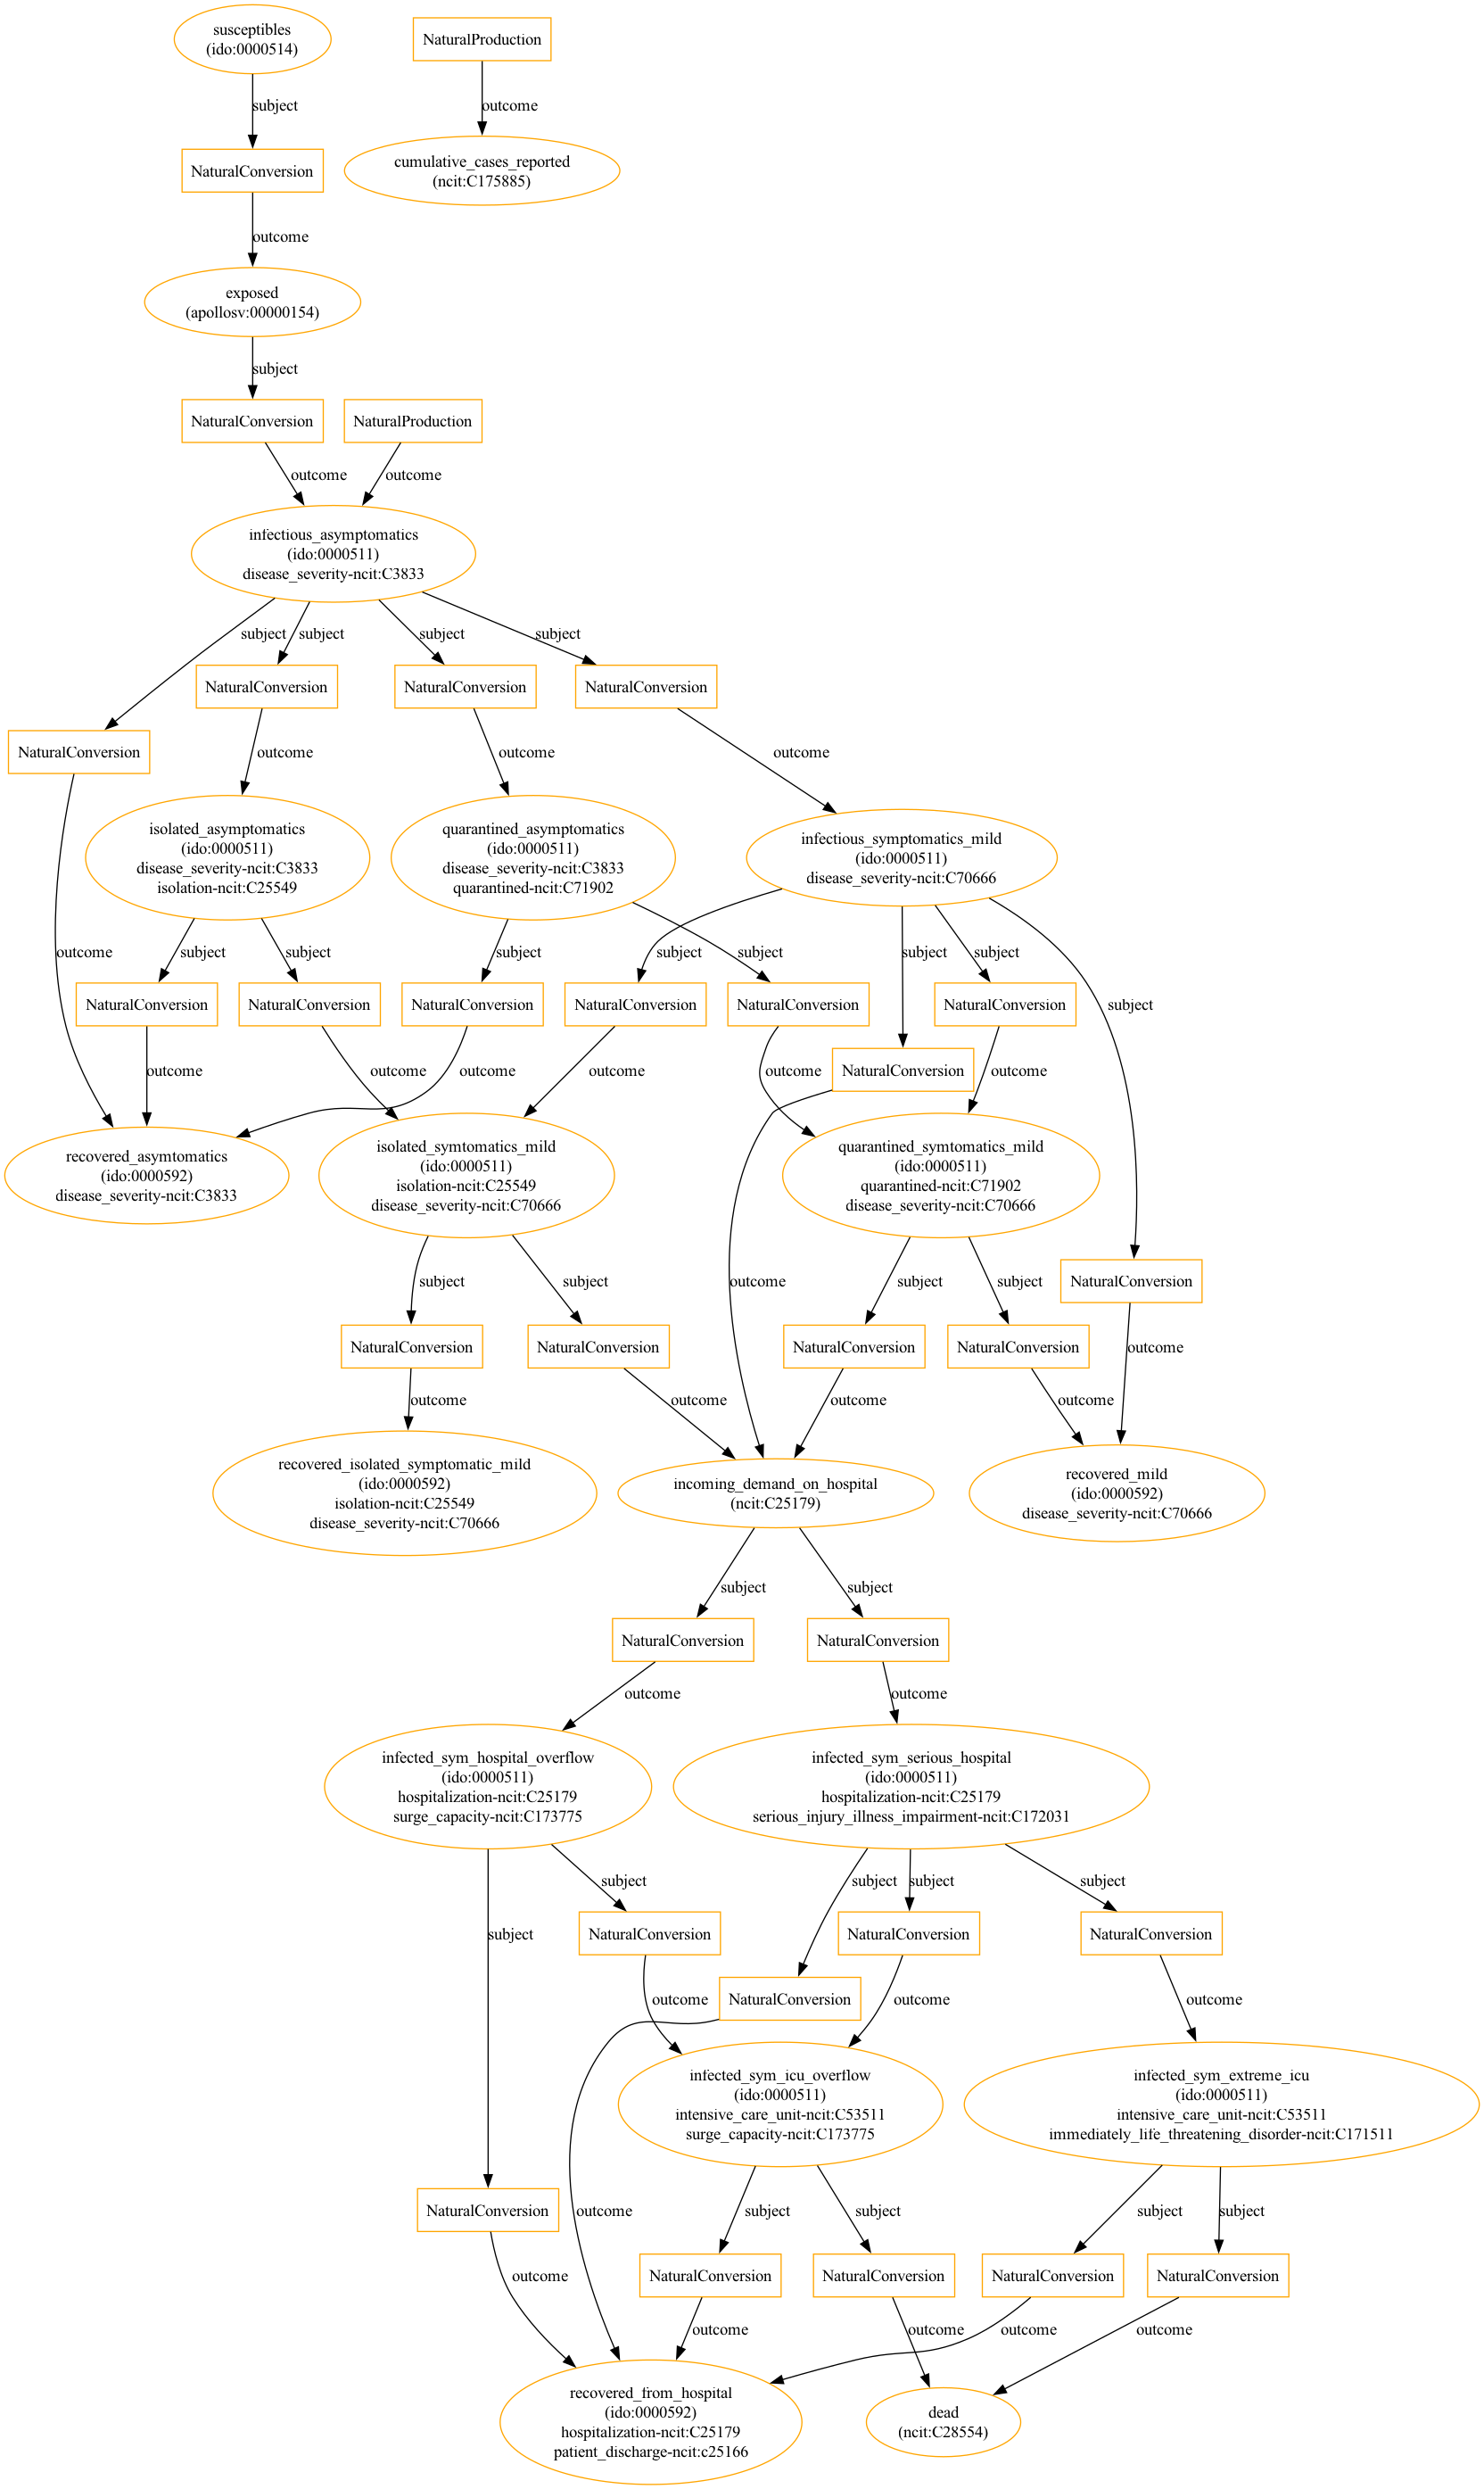

In [19]:
tm.draw_jupyter('scenario5.png')

## Print the parameters and their values

In [20]:
rows = [
    (parameter_name, parameter.value)
    for parameter_name, parameter in tm.parameters.items()
       ]
pd.DataFrame(rows, columns=["name", "value"])

,name,value
0,open_duration,10.0
1,end_lockdown_time,400.0
2,april_14,50.0
3,policy_high_contact_tracing_and_isolation,0.0
4,base_contacts_other,6.0
...,...,...
76,sum_in_icu_overflow,0.0
77,sum_quarantine_asym,0.0
78,sum_recovered_asym,0.0
79,sum_recovered_mild,0.0


## Print Initial Values

In [21]:
rows = [
    (parameter_name, str(parameter.expression))
    for parameter_name, parameter in tm.initials.items()
]
pd.DataFrame(rows, columns=["name", "expression"])

,name,expression
0,cumulative_cases_reported,0.0
1,dead,0.0
2,exposed,0.0
3,incoming_demand_on_hospital,0.0
4,infected_sym_extreme_icu,0.0
5,infected_sym_hospital_overflow,0.0
6,infected_sym_icu_overflow,0.0
7,infected_sym_serious_hospital,0.0
8,infectious_asymptomatics,0.0
9,infectious_symptomatics_mild,0.0


## Print the templates and their associated rate laws

A majority of rate laws for templates are the placeholder value of 0 as their rate-laws contain built-in Vensim functions and involve operations with series data which MIRA does not support yet.

In [22]:
template_rate_laws = [
    (template.name, template.display_name, template.rate_law)
    for template in tm.templates
]
pd.DataFrame(template_rate_laws, columns=["name", "display_name", "rate_law"])

,name,display_name,rate_law
0,1,deaths,"fr_fatality*delay3i(icu_admissions, delay_for_..."
1,2,deaths_overflow,net_fr_fatality*delay3i(into_inf_sym_icu_overf...
2,3,disease_progression,"(-fr_iso + q_sym + 1)*delay3i(symptom_setting,..."
3,4,exposure,contacts_total_per_susceptible*infectivity*sus...
4,5,hospital_admissions,"Min(managable_hospital_inflow, incoming_demand..."
5,6,hospital_overflow,"Max(0, incoming_demand_on_hospital/time_step -..."
6,7,icu_admissions,"Min(managable_icu_inflow, typical_worsening_rate)"
7,8,icu_overflow,"Max(0, -managable_icu_inflow + typical_worseni..."
8,9,incubation_rate_iso,fr_developing_symptoms*delay3i(isolation_rate_...
9,10,incubation_rate_quarantines,fr_developing_symptoms*delay3i(quarantining_ra...


## Display the output Stock and Flow amr for the MIRA template model created from ingesting the Vensim model

In [23]:
# FIXME need to get header information in there correctly

annotations = Annotations(name="February 2024 Hackathon - Scenario 5")
tm.annotations = annotations

amr = template_model_to_stockflow_json(tm)
HERE.joinpath("scenario_5_stockflow.json").write_text(json.dumps(amr, indent=2))
amr

{'header': {'name': 'February 2024 Hackathon - Scenario 5',
  'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/stockflow_v0.1/stockflow/stockflow_schema.json',
  'description': 'February 2024 Hackathon - Scenario 5',
  'schema_name': 'stockflow',
  'model_version': '0.1'},
 'properties': {},
 'model': {'flows': [{'id': '1',
    'name': 'deaths',
    'upstream_stock': 'infected_sym_extreme_icu',
    'downstream_stock': 'dead',
    'rate_expression': 'fr_fatality*delay3i(icu_admissions, delay_for_death, 0)',
    'rate_expression_mathml': '<apply><times/><ci>fr_fatality</ci><apply><delay3i/><ci>icu_admissions</ci><ci>delay_for_death</ci><cn>0</cn></apply></apply>'},
   {'id': '2',
    'name': 'deaths_overflow',
    'upstream_stock': 'infected_sym_icu_overflow',
    'downstream_stock': 'dead',
    'rate_expression': 'net_fr_fatality*delay3i(into_inf_sym_icu_overflow, delay_for_death, 0)',
    'rate_expression_mathml': '<apply><times/><ci>net_fr_fatality</ci><a